In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('/kaggle/input/dsp-project/portrait_emotions_labels.csv')
df

,filename,emotion,label
0,image_06637.jpg,angry,1
1,image_06638.jpg,angry,1
2,image_06639.jpg,disgust,6
3,image_06641.jpg,neutral,7
4,image_06642.jpg,sad,2
...,...,...,...
5831,image_08036.jpg,angry,1
5832,image_08035.jpg,neutral,7
5833,image_08038.jpg,sad,2
5834,image_08028.jpg,fear,4


In [3]:
df_test = pd.read_csv('/kaggle/input/dsp-project/rijks_emotion_cluster1.csv')
df_test

,filename,emotion
0,img_1.jpg,surprised
1,img_10.jpg,disgust
2,img_100.jpg,angry
3,img_101.jpg,fear
4,img_102.jpg,angry
...,...,...
761,img_95.jpg,surprised
762,img_96.jpg,surprised
763,img_97.jpg,happy
764,img_98.jpg,happy


In [4]:
def categorize(row):
    if row['emotion'] == 'angry':
        return 1
    elif row['emotion'] == 'sad':
        return 2
    elif row['emotion'] == 'happy':
        return 3
    elif row['emotion'] == 'fear':
        return 4
    elif row['emotion'] == 'surprised':
        return 5
    elif row['emotion'] == 'disgust':
        return 6
    else:
        return 7

In [5]:
df_test['label'] = df_test.apply(lambda x: categorize(x), axis=1)
df_test

,filename,emotion,label
0,img_1.jpg,surprised,5
1,img_10.jpg,disgust,6
2,img_100.jpg,angry,1
3,img_101.jpg,fear,4
4,img_102.jpg,angry,1
...,...,...,...
761,img_95.jpg,surprised,5
762,img_96.jpg,surprised,5
763,img_97.jpg,happy,3
764,img_98.jpg,happy,3


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

[Text(0, 0, '696'),
 Text(0, 0, '1122'),
 Text(0, 0, '1231'),
 Text(0, 0, '1415'),
 Text(0, 0, '1113'),
 Text(0, 0, '257'),
 Text(0, 0, '2')]

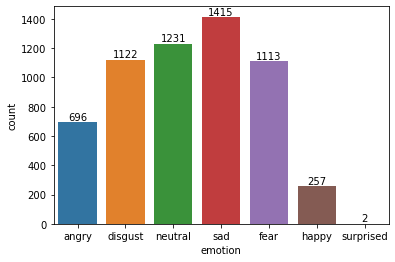

In [7]:
ax = sns.countplot(x='emotion',data=df)
ax.bar_label(ax.containers[0])

[Text(0, 0, '62'),
 Text(0, 0, '174'),
 Text(0, 0, '79'),
 Text(0, 0, '48'),
 Text(0, 0, '253'),
 Text(0, 0, '131'),
 Text(0, 0, '19')]

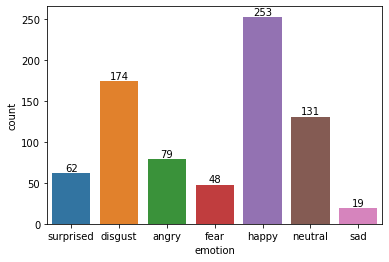

In [8]:
ax = sns.countplot(x='emotion',data=df_test)
ax.bar_label(ax.containers[0])

In [9]:
from keras.preprocessing.image import img_to_array, load_img
import os

path = '/kaggle/input/dsp-project/portrait_faces_preprocessed/portrait_faces_preprocessed'

X_train = []
for i in range(0, len(df)):
    image = load_img(os.path.join(path, df['filename'].iloc[i]), target_size=(224, 224))
    X_train.append(img_to_array(image))

X_train = np.array(X_train)

num_samples, height, width, channels = X_train.shape
X_train = X_train.reshape((num_samples, height * width * channels))
y_train = df['label']

In [10]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='minority')
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, '695'),
 Text(0, 0, '1415'),
 Text(0, 0, '1415'),
 Text(0, 0, '1113'),
 Text(0, 0, '1122'),
 Text(0, 0, '1233')]

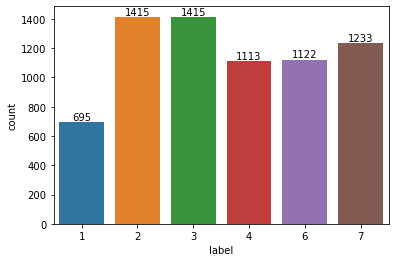

In [11]:
ax = sns.countplot(y_resampled[1:])
ax.bar_label(ax.containers[0])

In [12]:
print(X_resampled[0])
print(len(X_resampled))

[38. 23. 18. ... 57. 49. 38.]
6994


In [13]:
from keras.preprocessing.image import array_to_img
from PIL import Image

os.makedirs('/kaggle/working/resampled_portrait_faces')

for i in range(0, len(X_resampled)):
    image_array = X_resampled[i]
    image_array = image_array.reshape((height, width, channels))
    img = Image.fromarray(np.uint8(image_array))
    img.save('/kaggle/working/resampled_portrait_faces/img-%d.jpg' % i)

In [14]:
resampled_filenames = ['img-%d.jpg' % i for i in range(0, len(X_resampled))]
df_train = pd.DataFrame({'filename': resampled_filenames, 'label': y_resampled})

In [15]:
df_train

,filename,label
0,img-0.jpg,1
1,img-1.jpg,1
2,img-2.jpg,6
3,img-3.jpg,7
4,img-4.jpg,2
...,...,...
6989,img-6989.jpg,3
6990,img-6990.jpg,3
6991,img-6991.jpg,3
6992,img-6992.jpg,3


In [16]:
import cv2
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torchvision.io import read_image
from torchvision.transforms import ToTensor, ToPILImage, Normalize, Compose

In [17]:
training_data = []

for i in range(0, len(df_train)):
    image, label = df_train.iloc[i]['filename'], df_train.iloc[i]['label']
    path = '/kaggle/working/resampled_portrait_faces/' + image
    new_row = [path, int(label)]
    training_data.append(new_row)

In [18]:
print(len(training_data))

6994


In [19]:
train_set = training_data[0:int(len(training_data) * 0.8)]
validation_set = training_data[int(len(training_data) * 0.8):]
print(len(train_set) + len(validation_set))

6994


In [20]:
test_set_filename = []
test_set = []

for i in range(0, len(df_test)):
    image, label = df_test.iloc[i]['filename'].rsplit('/', 1)[-1], df_test.iloc[i]['label']
    path = '/kaggle/input/dsp-project/cropped_images_preprocessed/cropped_images_preprocessed/' + image
    new_row = [path, int(label)]
    test_set_filename.append(image)
    test_set.append(new_row)

In [21]:
print(len(test_set))

766


In [22]:
# Create a map for the labels and their codes
labels = ['angry', 'sad', 'happy', 'fear', 'surprise', 'disgust', 'neutral']
class_map = {}
i = 1
    
for label in labels:
    class_map[i] = label
    i += 1

In [23]:
print(class_map)

{1: 'angry', 2: 'sad', 3: 'happy', 4: 'fear', 5: 'surprise', 6: 'disgust', 7: 'neutral'}


In [24]:
# Class for loading of the data
class own_data(Dataset):
    def __init__(self, train=0, transform=None):
        if train == 0:
            self.data = train_set
        elif train == 1:
            self.data = validation_set
        else:
            self.data = test_set
            
        self.transform = transform
        self.to_pil = ToPILImage()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_id = self.data[idx]
        image = read_image(img_path)
        
        if self.transform:
            image = self.transform(self.to_pil(image))
        
        return image, class_id

In [25]:
from torchvision.models import alexnet

model = alexnet(pretrained=True)
model.load_state_dict(torch.load('/kaggle/input/model-alexnet/alexnet_base'))

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

<All keys matched successfully>

In [26]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [27]:
# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False
    
# Change the final layer of AlexNet Model for Transfer Learning
model.classifier = nn.Sequential(
    nn.Linear(in_features=9216, out_features=4096), 
    nn.ReLU(inplace=True), 
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True), 
    nn.ReLU(inplace=True), 
    nn.Dropout(p=0.5, inplace=False), 
    nn.Linear(in_features=4096, out_features=7, bias=True)
)

print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dro

In [28]:
preprocess = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [29]:
# Initialize the batch size
batch_size = 64

# Load the train and test data
train_data = own_data(0, preprocess)
validation_data = own_data(1, preprocess)
test_data = own_data(2, preprocess)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [30]:
model.train()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dro

In [31]:
cross = nn.CrossEntropyLoss()
sgd = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [32]:
# Define the train model function
def train_model(train_loader, model, loss_function, optimizer, batch_size, device=None):
    for batch, (image, label) in enumerate(train_loader):
        # Move labels and images to GPU
        image = image.cuda()
        label = label.cuda()

        optimizer.zero_grad()
        output = model(image)
        label = label - 1
        loss_func = loss_function(output, label)
        loss_func.backward()
        optimizer.step()
        
        if batch % 64 == 0:
            print('[%5d] loss: %.3f' % (batch + 1, loss_func.item()))

In [33]:
# Test function
def validate_model(validation_loader, model, loss_function, batch_size, device=None):
    size = len(validation_loader.dataset)
    validation_loss, correct = 0, 0
    
    with torch.no_grad():
        for image, label in validation_loader:
            # Move labels and images to GPU
            image = image.cuda()
            label = label.cuda()
            
            output = model(image)
            label = label - 1
            validation_loss += loss_function(output, label).item()
            correct += (output.argmax(1) == label).type(torch.float).sum().item()
    
    validation_loss /= batch_size
    correct /= size
    print(f"Test error: \n Accuracy: {(100 * correct):>0.01f}%, Avg loss: {validation_loss:>8f} \n")

In [34]:
device = None

if device == None:
    if torch.cuda.is_available():
        print("CUDA used")
        device = torch.device('cuda')
        model.cuda()

        # Should be > 0
        print(torch.cuda.device_count())

        # Index of device used (can be 0)
        print(torch.cuda.current_device())

        # GPU location
        print(torch.cuda.device(0))

        # Name of GPU
        print(torch.cuda.get_device_name(0))

    else:
        print("CPU used")
        device = torch.device('cpu')

# Force CPU use
# device = torch.device('cpu')

CUDA used
1
0
Tesla P100-PCIE-16GB


In [35]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train()
    train_model(train_loader, model, cross, sgd, batch_size, device=device)
    model.eval()
    validate_model(validation_loader, model, cross, batch_size, device=device)
print("Done!")

Epoch 1
-------------------------------
[    1] loss: 1.986
[   65] loss: 1.157
Test error: 
 Accuracy: 13.0%, Avg loss: 0.918224 

Epoch 2
-------------------------------
[    1] loss: 0.916
[   65] loss: 1.009
Test error: 
 Accuracy: 19.2%, Avg loss: 0.777329 

Epoch 3
-------------------------------
[    1] loss: 0.606
[   65] loss: 0.758
Test error: 
 Accuracy: 31.7%, Avg loss: 0.646345 

Epoch 4
-------------------------------
[    1] loss: 0.825
[   65] loss: 0.890
Test error: 
 Accuracy: 22.3%, Avg loss: 0.744751 

Epoch 5
-------------------------------
[    1] loss: 0.524
[   65] loss: 0.475
Test error: 
 Accuracy: 26.3%, Avg loss: 0.656440 

Epoch 6
-------------------------------
[    1] loss: 0.505
[   65] loss: 0.472
Test error: 
 Accuracy: 46.5%, Avg loss: 0.449998 

Epoch 7
-------------------------------
[    1] loss: 0.453
[   65] loss: 0.516
Test error: 
 Accuracy: 33.8%, Avg loss: 0.635756 

Epoch 8
-------------------------------
[    1] loss: 0.682
[   65] loss: 0.

In [36]:
torch.save(model.state_dict(), '/kaggle/working/model_alexnet_resampled')

In [6]:
model.load_state_dict(torch.load('/kaggle/input/model-alexnet/model_alexnet'))

<All keys matched successfully>

In [37]:
model.eval()

def test_model(test_loader, model, device=None):
    predictions = []
    
    with torch.no_grad():
        for image, label in test_loader:
            # Move to GPU
            image = image.to(device)
            label = label.to(device)
            
            output = model(image)
            prediction = (output.argmax(1)).cpu().detach().numpy()
            predictions.extend(prediction)
    
    return predictions

In [38]:
predictions = test_model(test_loader, model, device)

In [39]:
predictions = [x + 1 for x in predictions]

In [40]:
rijks_prediction = pd.DataFrame(
    {'filename': test_set_filename,
     'label': predictions
    }
)

rijks_prediction

,filename,label
0,img_1.jpg,4
1,img_10.jpg,4
2,img_100.jpg,7
3,img_101.jpg,3
4,img_102.jpg,7
...,...,...
761,img_95.jpg,4
762,img_96.jpg,3
763,img_97.jpg,1
764,img_98.jpg,3


In [41]:
rijks_prediction.rename(columns = {'label': 'predicted_label'}, inplace=True)
rijks_prediction['actual_label'] = df_test['label']
rijks_prediction

,filename,predicted_label,actual_label
0,img_1.jpg,4,5
1,img_10.jpg,4,6
2,img_100.jpg,7,1
3,img_101.jpg,3,4
4,img_102.jpg,7,1
...,...,...,...
761,img_95.jpg,4,5
762,img_96.jpg,3,5
763,img_97.jpg,1,3
764,img_98.jpg,3,3


In [42]:
correct = (rijks_prediction['predicted_label'] == rijks_prediction['actual_label'])
accuracy = (correct.sum() / correct.size) * 100
accuracy

27.023498694516974

In [43]:
rijks_prediction.to_csv('/kaggle/working/alexnet_predictions_resampled', index=False)

**Loading predictions generated to build confusion matrix + classification report**

In [44]:
rijks_prediction = pd.read_csv('/kaggle/input/model-alexnet/alexnet_predictions_resampled')
rijks_prediction

,filename,predicted_label,actual_label
0,img_1.jpg,4,5
1,img_10.jpg,4,6
2,img_100.jpg,7,1
3,img_101.jpg,3,4
4,img_102.jpg,7,1
...,...,...,...
761,img_95.jpg,4,5
762,img_96.jpg,3,5
763,img_97.jpg,1,3
764,img_98.jpg,3,3


In [45]:
labels = ['angry', 'sad', 'happy', 'fear', 'surprised', 'disgust', 'neutral']

# Convert predictions into a numpy array
y_preds = np.array(rijks_prediction['predicted_label'].values)

# Convert test labels into a numpy array
y_test = np.array(rijks_prediction['actual_label'].values)

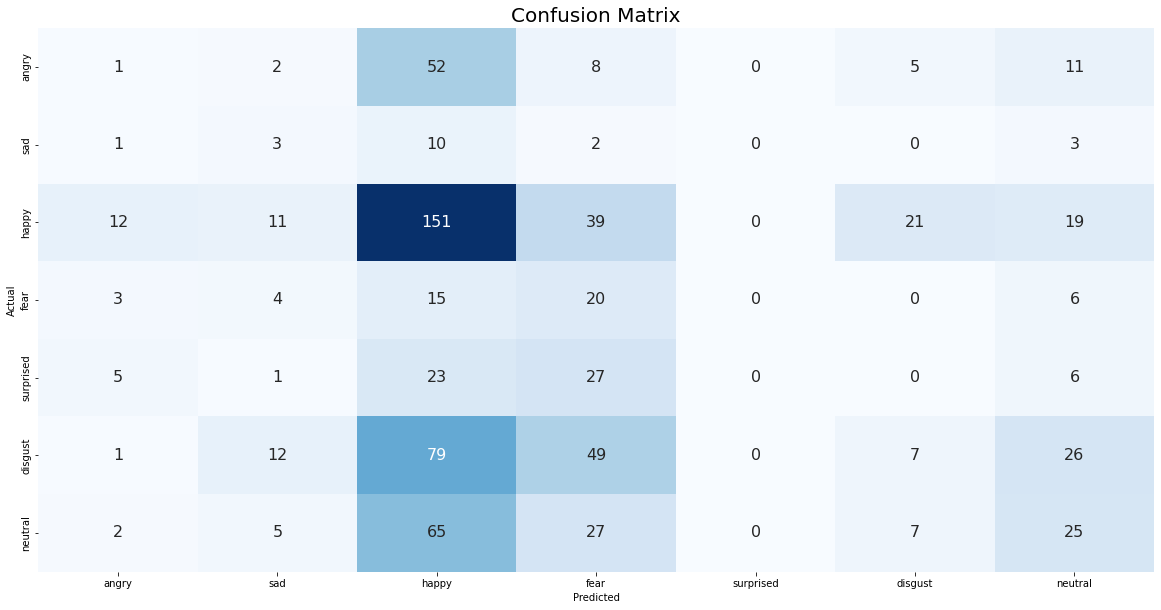

In [46]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm_data = confusion_matrix(y_test, y_preds)
cm = pd.DataFrame(cm_data, columns=labels, index=labels)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [47]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           1       0.04      0.01      0.02        79
           2       0.08      0.16      0.11        19
           3       0.38      0.60      0.47       253
           4       0.12      0.42      0.18        48
           5       0.00      0.00      0.00        62
           6       0.17      0.04      0.07       174
           7       0.26      0.19      0.22       131

    accuracy                           0.27       766
   macro avg       0.15      0.20      0.15       766
weighted avg       0.22      0.27      0.22       766



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
